In [83]:
%matplotlib inline
from IPython import display
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"


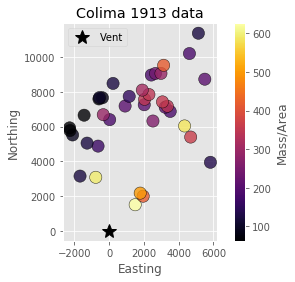

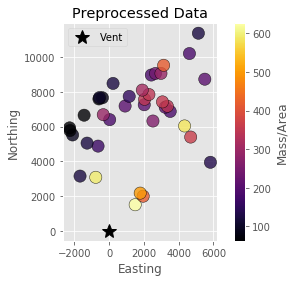

In [84]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display.display(raw_df.head())

vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17, 37, 31])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)
obs_df = obs_df.sort_values(by=['radius'])

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [86]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

display.display(config)
display.display(globs)



{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5.0,
 'MIN_GRAINSIZE': 4.0,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

In [89]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

del theo_phi_steps[-1]
del theo_phi_steps[-1]


display.display(pd.DataFrame(theo_phi_steps))


,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2


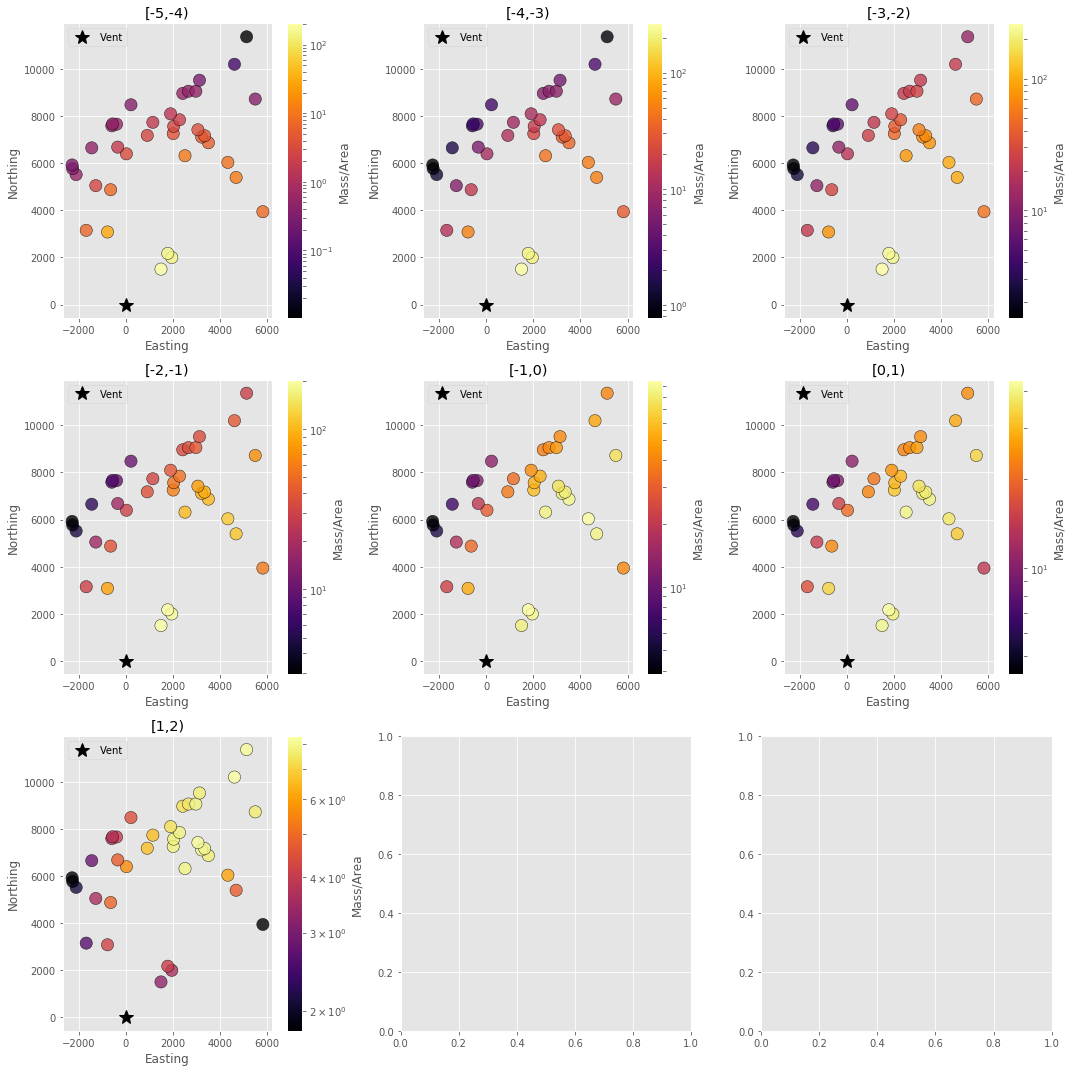

Int64Index([16, 18, 17, 37, 31, 36, 35, 34, 33, 32,  6, 28, 11, 30, 20, 21,  7,
            22, 12, 29, 14,  5, 24, 23,  4, 19, 26, 25, 27,  1, 13,  8,  3, 15,
             0,  2,  9, 10],
           dtype='int64')


In [90]:
sep_phis = []

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, phi in enumerate(theo_phi_steps):
    df, _, _, _ = io.read_tephra2("data/colima/colima_gs_trial/colima_%d_out.txt"%i)
    sep_phis += [df]
    vis.plot_sample(sep_phis[i], vent=(0,0), ax=axs[i], 
                    title="%s"%phi["interval"], cbar_label="Mass/Area")
plt.tight_layout()
plt.show()

print(obs_df.index)

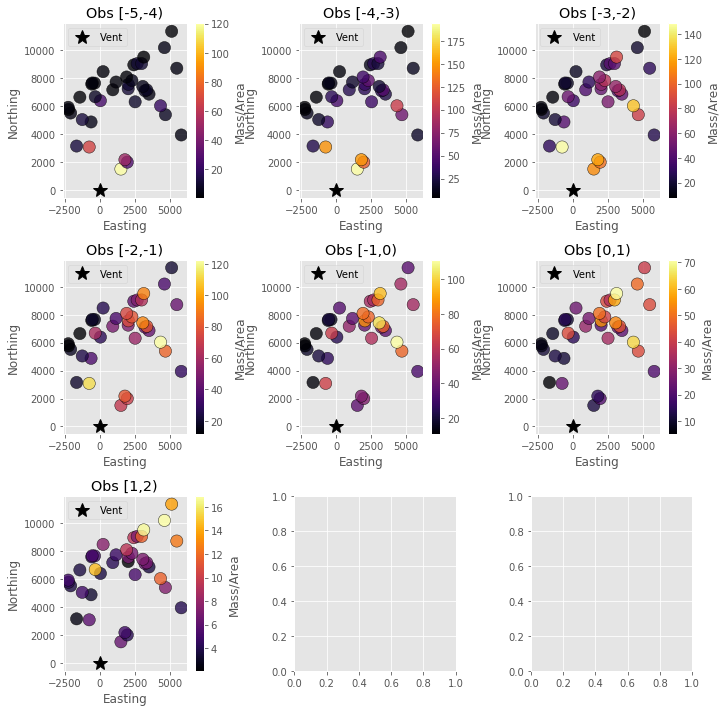

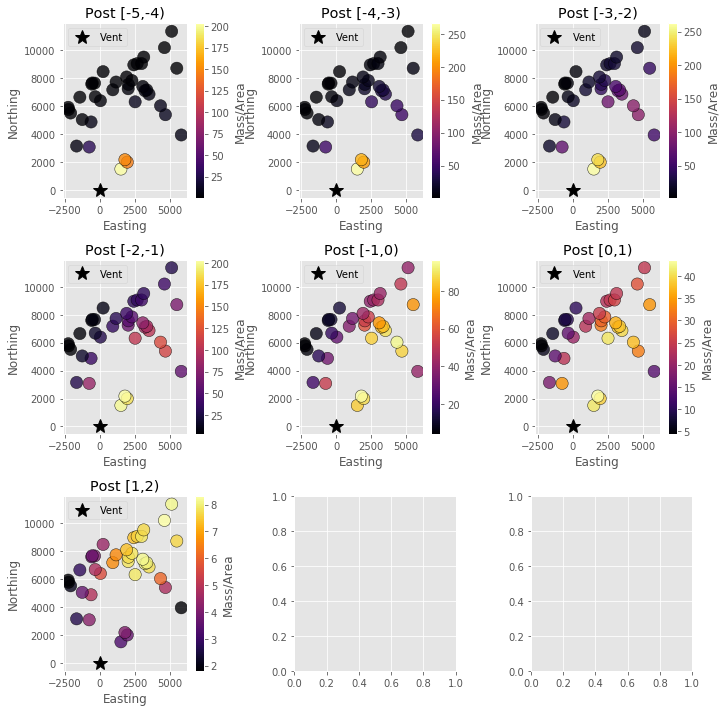

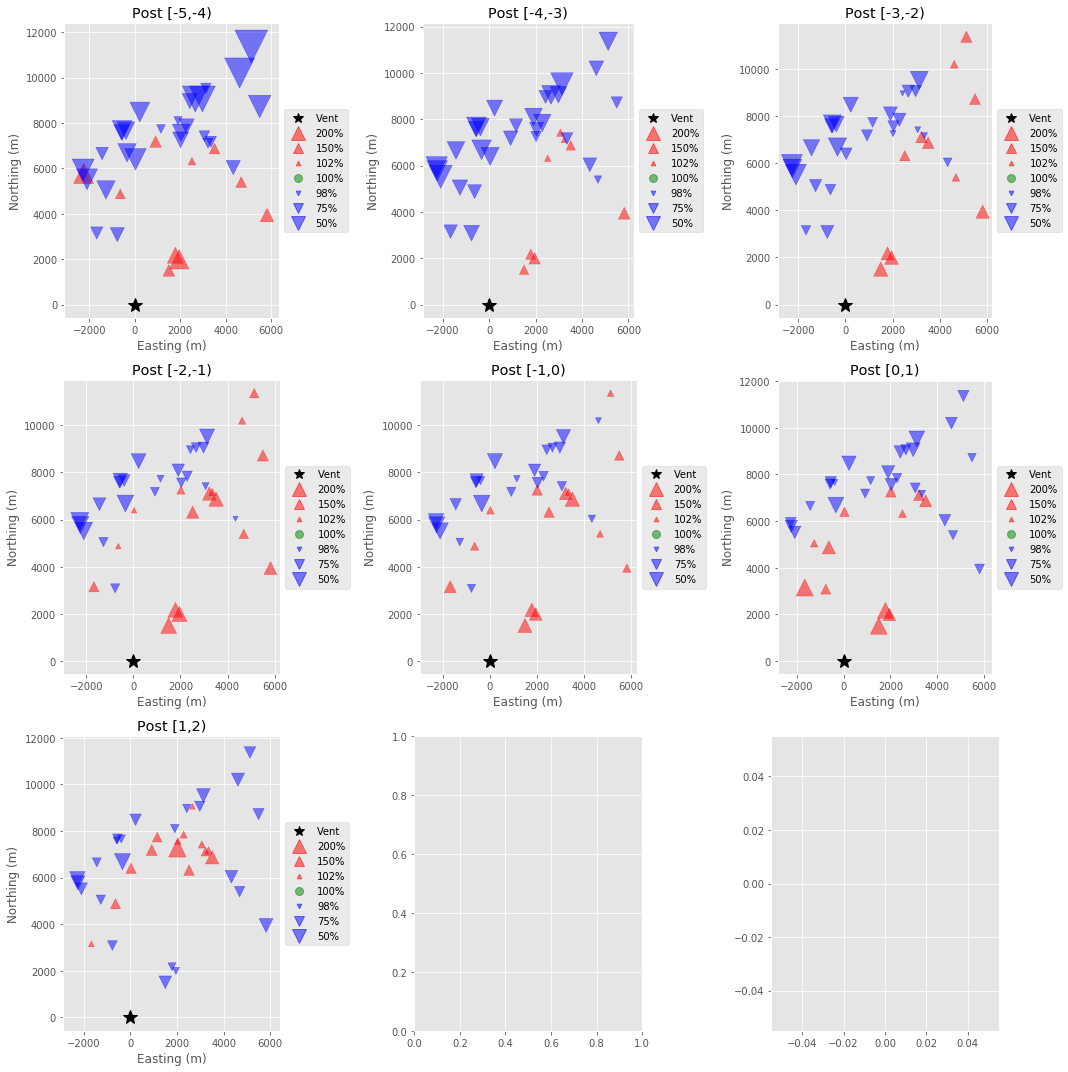

In [91]:
observation_phis = []
posterior_phis = []

prior_phi_steps = theo_phi_steps.copy()

for j, phi_step in enumerate(theo_phi_steps):
    phi_obs = obs_df.copy()
    phi_obs["MassArea"] = phi_obs["MassArea"]*phi_obs[phi_step["interval"]]/100
    phi_obs[phi_step["interval"]] = 100
    bounds=(0, 200)

    observation_phis += [phi_obs]

    phi_post = sep_phis[j].copy()
    phi_post["radius"] = np.sqrt(phi_post["Easting"]**2 + phi_post["Northing"]**2)
    phi_post = phi_post.sort_values(by=['radius'])
    phi_post["Residual"] = phi_post["MassArea"].values/phi_obs["MassArea"].values
    
    posterior_phis += [phi_post]

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Obs %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            10, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_sample(posterior_phis[j], vent=(0,0), log=False,#bounds=bounds, 
                   title="Post %s"%phi_step["interval"], cbar_label="Mass/Area", ax=axs[j])
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    vis.plot_residuals(posterior_phis[j], vent=(0,0), plot_type="size",
                   title="Post %s"%phi_step["interval"], ax=axs[j])
    
plt.tight_layout()
plt.show()

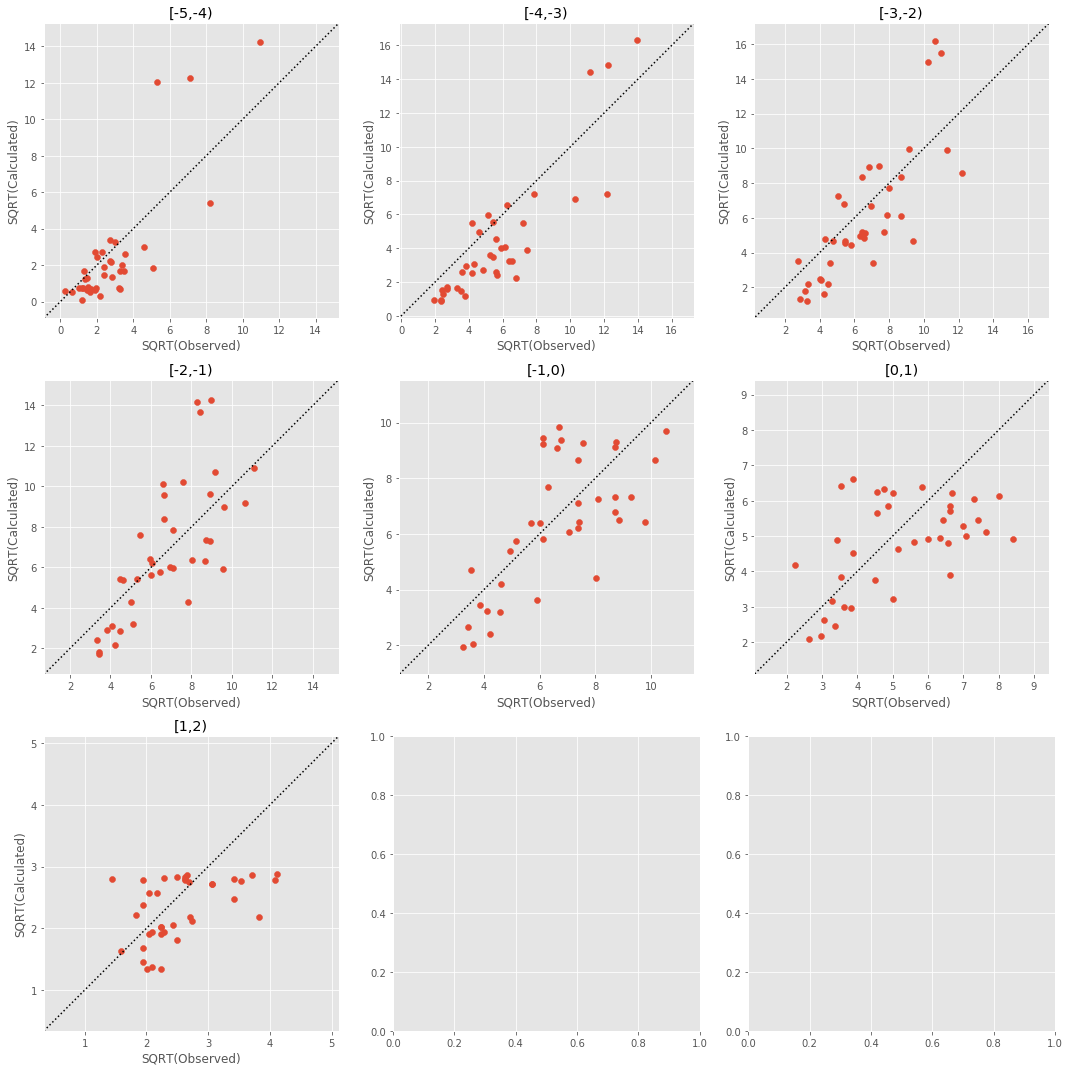

In [92]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    min_mass = min((min(observation_phis[j]["MassArea"].values), min(posterior_phis[j]["MassArea"].values)))
    max_mass = max((max(observation_phis[j]["MassArea"].values), max(posterior_phis[j]["MassArea"].values)))
    axs[j].scatter(np.sqrt(observation_phis[j]["MassArea"].values), np.sqrt(posterior_phis[j]["MassArea"].values))
    axs[j].plot([-100,100],[-100,100], "k:")
    axs[j].set_xlabel("SQRT(Observed)")
    axs[j].set_ylabel("SQRT(Calculated)")
    axs[j].set_aspect('equal', 'box')
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    axs[j].set_ylim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    
plt.tight_layout()
plt.show()

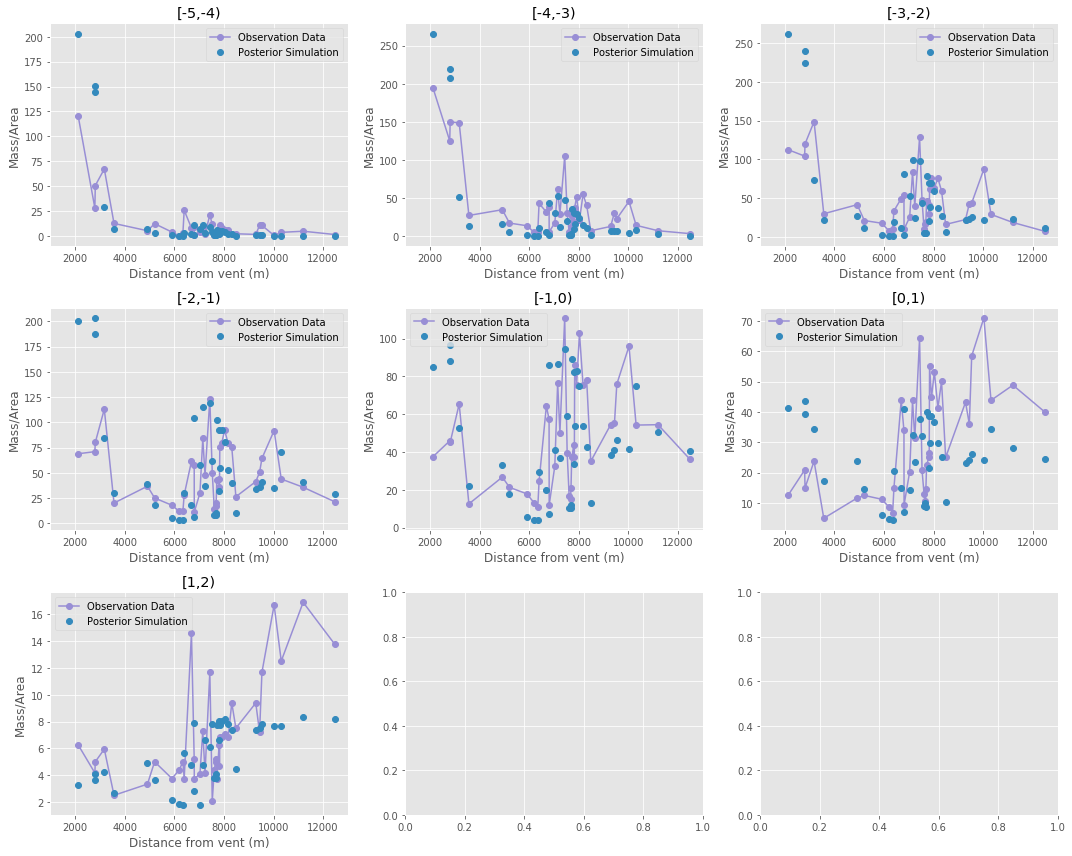

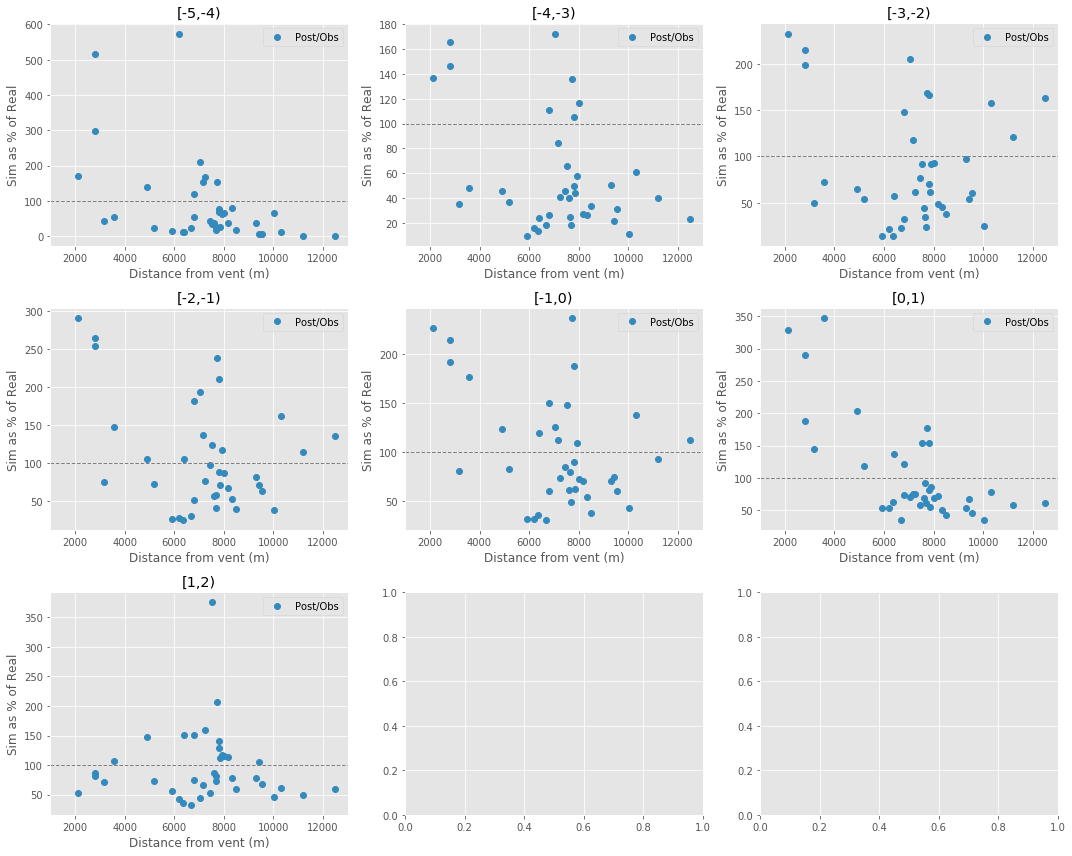

In [93]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"].values, observation_phis[j]["MassArea"].values, 'C2o-', label="Observation Data")
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[j].legend()
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_ylabel("Mass/Area")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(posterior_phis[j]["radius"].values, posterior_phis[j]["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[j].axhline(100, linestyle="--", lw=1, c="gray")  
    axs[j].legend()
    axs[j].set_xlabel("Distance from vent (m)")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_ylabel("Sim as % of Real")
    axs[j].set_xlim(1000, 13000)
    
plt.tight_layout()
plt.show()

In [116]:
def misfit_sse(observed, expected):
    return ((observed - expected)**2)/expected

contributions = np.zeros((len(prior_phi_steps), len(observation_phis[0])))
RMSE_contributions = np.zeros((len(prior_phi_steps), len(observation_phis[0])))
print(contributions.shape)
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["MassArea"].values
    for i in range(len(posterior_phis[j])):
        observed = observation_phis[j]["MassArea"].values[i]
        expected = posterior_phis[j]["MassArea"].values[i]
        misfit = ((observed - expected)**2)/expected
        RMSE = ((observed - expected)**2)
        contributions[j,i] = misfit
        RMSE_contributions[j,i] = RMSE
    
RMSE_point_contributions = np.sqrt(np.sum(RMSE_contributions, 0)/38)
RMSE_phi_contributions = np.sqrt(np.sum(RMSE_contributions, 1)/9)

point_contributions = np.sum(contributions, 0)
phi_contributions = np.sum(contributions, 1)

total_misfit = np.sum(np.sum(contributions))

total_RMSE = np.sqrt(np.sum(np.sum(RMSE_contributions))/38)

total_NRMSE = total_RMSE/(np.max(obs_df["MassArea"].values) - np.min(obs_df["MassArea"].values))
display.display(phi_contributions)
print(total_misfit)
print(total_RMSE)
print(total_NRMSE)

(7, 38)


array([1435.42062936, 1642.52560046, 1120.67738818,  782.96234907,
        549.5124    ,  445.33470117,   87.07324897])

6063.506317217903
80.87688879895666
0.14359733105883432


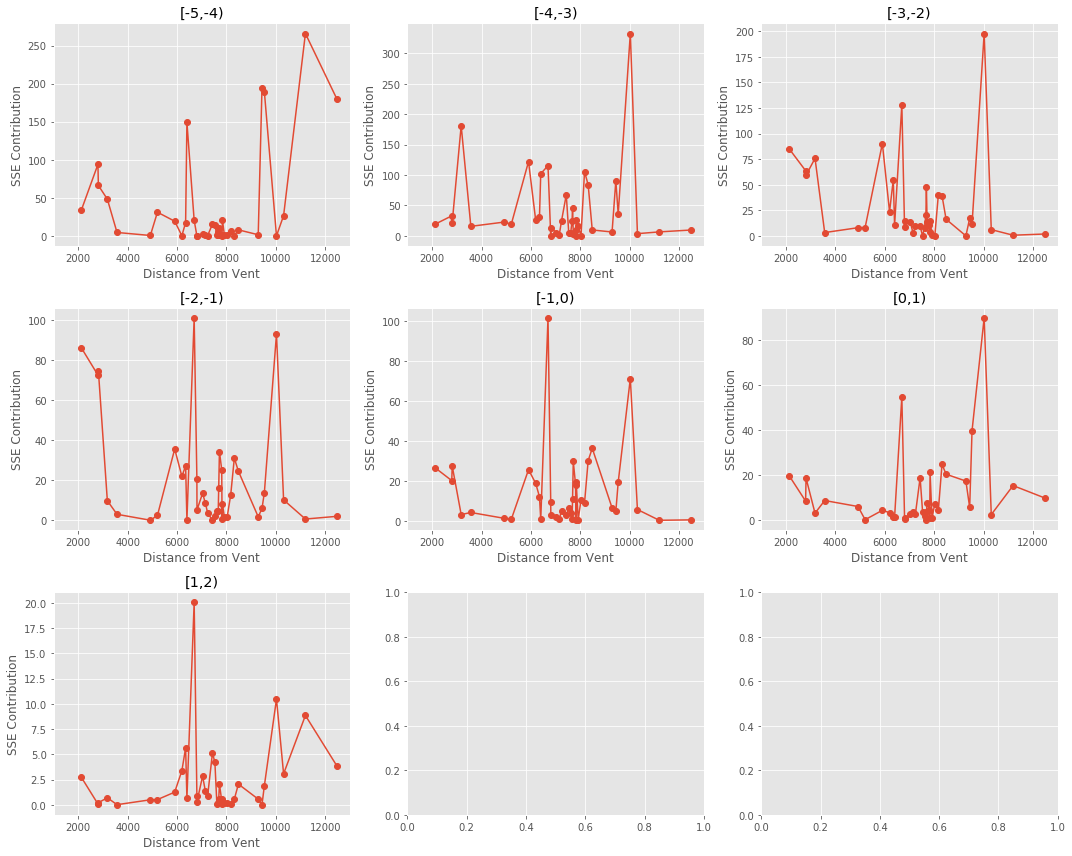

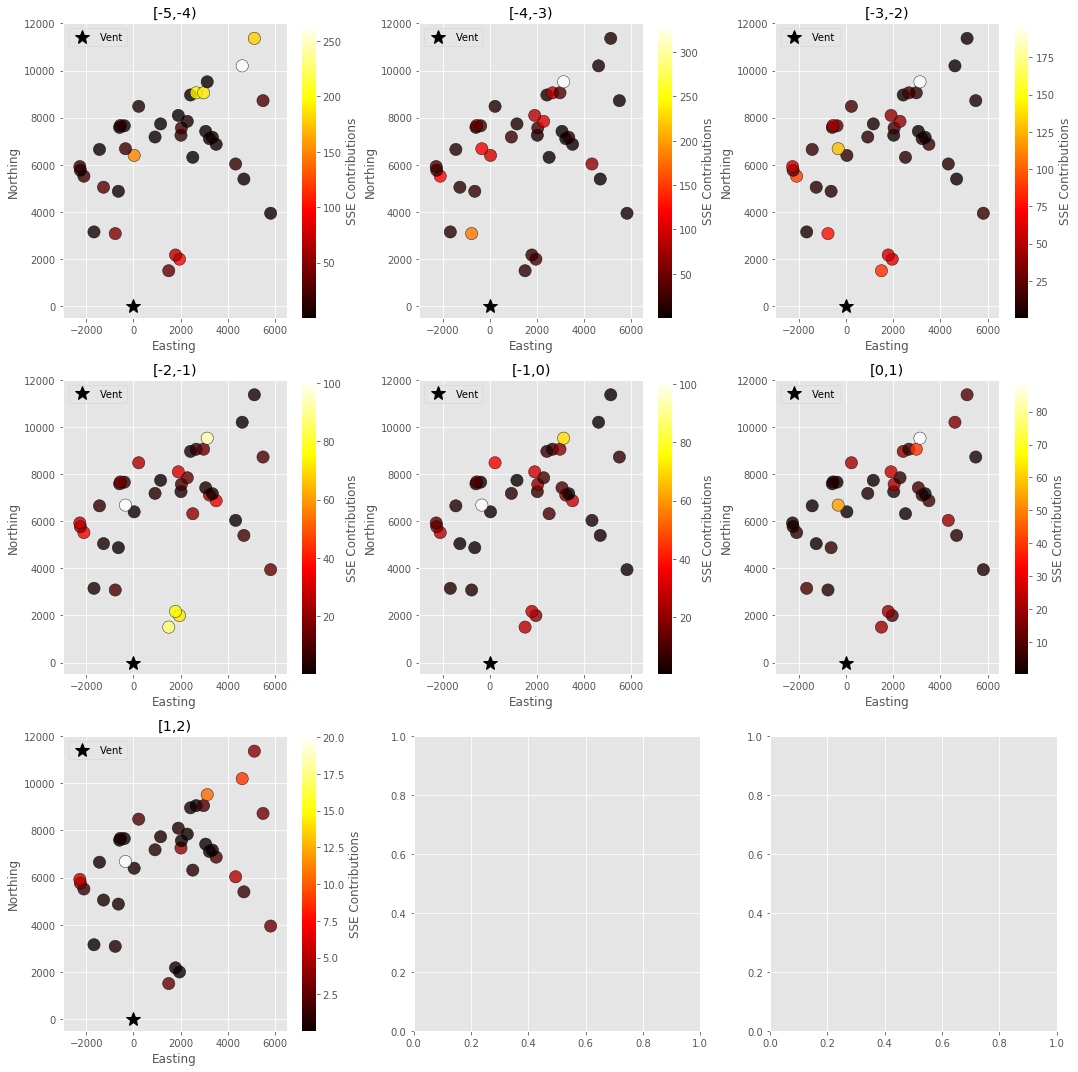

In [100]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"], contributions[j,:], "C0o-")
    axs[j].set_xlabel("Distance from Vent")
    axs[j].set_ylabel("SSE Contribution")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim(1000, 13000)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["Contributions"] = contributions[j,:]
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False, values="Contributions",
                title="SSE Contributions", cbar_label="SSE Contributions", ax = axs[j], cmap="hot")
    axs[j].set_xlim([-3000, 6500])
    axs[j].set_ylim([-500, 12000])
    axs[j].set_title(phi_step["interval"])

plt.tight_layout()
plt.show()

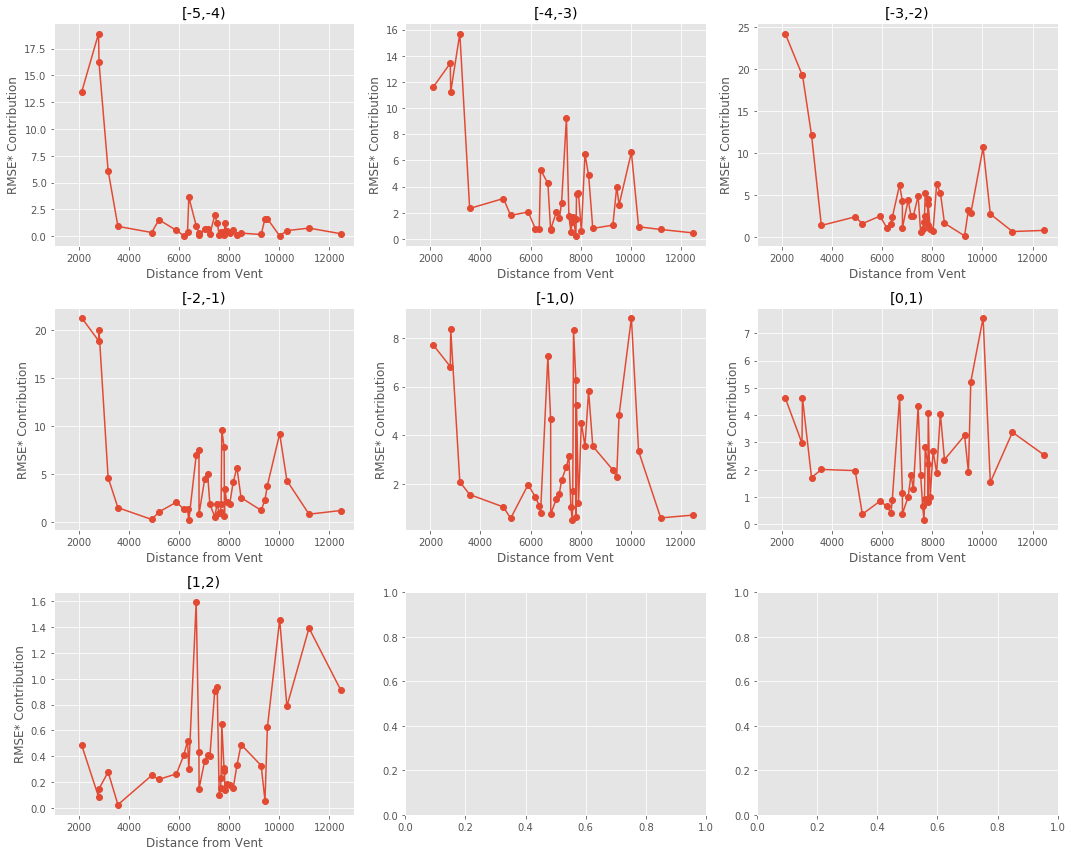

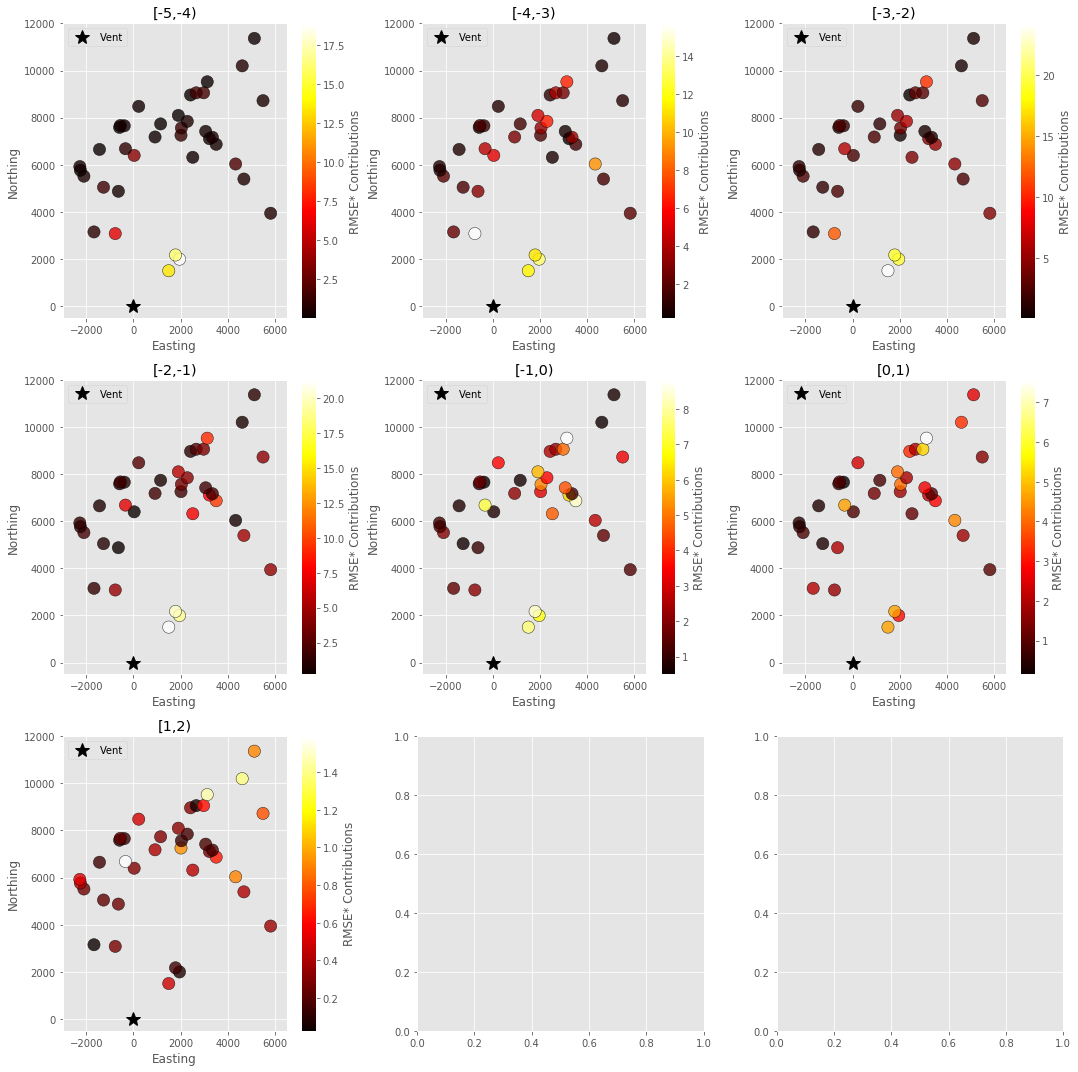

In [107]:
fig, axs = plt.subplots(3,3, figsize=(
            15, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    axs[j].plot(observation_phis[j]["radius"], np.sqrt(RMSE_contributions[j,:]/len(observation_phis[j])), "C0o-")
    axs[j].set_xlabel("Distance from Vent")
    axs[j].set_ylabel("RMSE* Contribution")
    axs[j].set_title(phi_step["interval"])
    axs[j].set_xlim(1000, 13000)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3,3, figsize=(
            15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j, phi_step in enumerate(prior_phi_steps):
    observation_phis[j]["Contributions"] = np.sqrt(RMSE_contributions[j,:]/len(observation_phis[j]))
    vis.plot_sample(observation_phis[j], vent=(0,0), log=False, values="Contributions", cbar_label="RMSE* Contributions", ax = axs[j], cmap="hot")
    axs[j].set_xlim([-3000, 6500])
    axs[j].set_ylim([-500, 12000])
    axs[j].set_title(phi_step["interval"])

plt.tight_layout()
plt.show()

In [109]:
row_labels = [phi["interval"] for phi in prior_phi_steps]

num_phis = len(theo_phi_steps)

cont_df = pd.DataFrame(data=contributions.T, columns=row_labels, index = obs_df.index)

min_phis = np.array([min(observation_phis[i]["MassArea"].values) for i in range(num_phis)])
print(min_phis)
max_phis = np.array([max(observation_phis[i]["MassArea"].values) for i in range(num_phis)])
print(max_phis)

#Total sum per column: 
cont_df.loc['Phi Total (RMSE)',:9]= np.sqrt(cont_df.sum(axis=0)/num_phis)
cont_df.loc['Phi Total (NRMSE)',:9] = np.sqrt(cont_df.sum(axis=0)/num_phis)/(max_phis-min_phis)

#Total sum per row: 
cont_df.loc[:38,'Point Total (RMSE*)'] = np.sqrt(cont_df.sum(axis=1)/38)
# cont_df.loc[:,'Point Total (NRMSE)'] = np.sqrt(cont_df.sum(axis=1)/38)

display.display(cont_df)

[ 0.06258  3.7548   7.5096  11.2644  10.6386   5.0064   2.086  ]
[120.1536 193.998  148.6275 122.6568 110.9752  70.924   16.8966]


,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)",Point Total (RMSE*)
16,33.9522,19.3687,85.3557,86.1126,26.511,19.9094,2.72492,2.68492
18,93.9918,32.9824,63.7635,72.5201,20.1089,8.56939,0.0788403,2.77211
17,66.3017,21.8662,59.3658,74.7215,27.4652,18.7774,0.206856,2.65917
37,48.2828,180.931,75.8326,9.83137,3.1232,3.23503,0.698405,2.91066
31,4.54443,15.7591,3.26913,3.04981,4.16454,8.83206,0.00985045,1.02121
36,0.597251,22.7466,8.02249,0.0963035,1.24919,6.18156,0.495424,1.01811
35,31.1386,19.1699,8.20453,2.48548,0.715947,0.349662,0.515605,1.28329
34,19.3144,122.133,90.2987,35.6282,25.5963,4.50112,1.25333,2.80378
33,0.245202,25.4889,23.7057,22.017,18.7436,3.45191,3.37433,1.59791
32,17.6196,30.5661,54.9609,27.1619,12.0803,1.48437,5.63716,1.98355


In [110]:
print(cont_df.loc['Phi Total (NRMSE)'][:9])

print(sum(cont_df.loc['Phi Total (NRMSE)'].values[:9]))

[-5,-4)                0.119836
[-4,-3)               0.0808935
[-3,-2)               0.0901669
[-2,-1)               0.0955827
[-1,0)                 0.089013
[0,1)                  0.122081
[1,2)                  0.242909
Point Total (RMSE*)         nan
Name: Phi Total (NRMSE), dtype: float64
nan


In [111]:
disp_cols = ["Easting",
            "Northing",
            "MassArea",
            "radius"]

display.display(observation_phis[-1][disp_cols].head())

display.display(posterior_phis[-1][disp_cols].head())

display.display(obs_df.head())

,Easting,Northing,MassArea,radius
16,1499,1506,6.258,"2,124.86"
18,1957,1997,4.172,"2,796.04"
17,1787,2173,5.0064,"2,813.41"
37,-770,3082,5.9451,"3,176.73"
31,-1673,3152,2.5032,"3,568.48"


,Easting,Northing,MassArea,radius
16,1499,1506,3.27203,"2,124.86"
18,1957,1997,3.63655,"2,796.04"
17,1787,2173,4.08694,"2,813.41"
37,-770,3082,4.22693,"3,176.73"
31,-1673,3152,2.66523,"3,568.48"


,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86",100
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04",100
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41",100
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73",100
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48",100
